In [65]:
import os
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

## ----- Imports -----
from utils import *
from modules import RNNModel, SeqDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F


DATETIME_STAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
new_dir_path = get_next_versioned_directory('rnn_training')
print(f"Created new directory: {new_dir_path}")

print(torch.__version__)
print(f"MPS available: {torch.backends.mps.is_available()}")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_type = "mps"
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_type = "cuda"
    print("CUDA device found.")
else:
    print ("Using CPU.")
    device_type = "cpu"
    device = torch.device("cpu")

SEED = 42
set_seed(SEED)

# Usage: call once before training
log_file = setup_logging(new_dir_path)
logging.info(f'Seed: {SEED}')

NUM_EPOCHS = 30
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
NUM_LAYERS = 1  # Number of GRU layers
CROSS_VAL = False # if True, cross validate on the split condition
# pairs of (config, roi) that are known to have good responses
good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]

# ==================== DATA FILTERING OPTIONS ====================
# Set to None to use all, or provide a list to filter

# Filter by configs (1-31). Set to None for all configs, or e.g., [1, 2, 3] for specific ones
FILTER_CONFIGS = None  # e.g., list(range(1, 11)) for configs 1-10, or [3, 7, 15]

# Filter by neurons/ROIs (1-indexed). Set to None for all neurons, or provide a list
# You can use good_pairs to extract neurons: [n for c, n in good_pairs]
# These neurons are used for initial conditions AND as the pool for targets
FILTER_NEURONS = None  # e.g., [21, 22, 23, 26, 27, 31] for specific neurons

# Target neurons to predict (1-indexed). Must be a subset of FILTER_NEURONS.
# Set to None to predict all FILTER_NEURONS, or provide a list for specific neurons
TARGET_NEURONS = set([pair[1] for pair in good_pairs])  # e.g., [31] to only predict neuron 31

# Filter by electrodes (0-9). Set to None for all electrodes
FILTER_ELECTRODES = None  # e.g., [0, 1, 2] for first 3 electrodes

# Filter by current levels (3, 4, 5). Set to None for all currents
FILTER_CURRENTS = None  # e.g., [5] for highest current only

# ================================================================

logging.info(f'Number of epochs {NUM_EPOCHS}')
logging.info(f'Cross validating {CROSS_VAL}')
logging.info(f'Target neurons for prediction {TARGET_NEURONS}')

checkpoint_filepath = os.path.join("rnn_training", DATETIME_STAMP, "best_model.pth")


data = scipy.io.loadmat('data.mat')
times = np.stack(data['times'][0, ...])
dfof = np.stack(data['dfof'][0, ...])
configs = np.stack( data['configs'][0, ...])
roi_used = data['roi_used']



# If filtering neurons, subset the dfof data to only include those neurons
if FILTER_NEURONS is not None:
    neuron_indices = [n - 1 for n in FILTER_NEURONS]  # Convert to 0-indexed
    dfof = np.array([session_dfof[:, neuron_indices] for session_dfof in dfof])
    logging.info(f"Filtered to {len(FILTER_NEURONS)} neurons: {FILTER_NEURONS}")
    logging.info(f"New dfof shape: {dfof.shape}")

# Validate and compute TARGET_NEURONS indices
# TARGET_NEURONS are the neurons to predict; must be subset of FILTER_NEURONS
if TARGET_NEURONS is None:
    # Default: predict all filtered neurons
    TARGET_NEURONS = FILTER_NEURONS if FILTER_NEURONS is not None else list(range(1, dfof[0].shape[1] + 1))
    target_indices = None  # Use all columns
else:
    # Validate that TARGET_NEURONS is a subset of FILTER_NEURONS (i.e. each target neuron should have an initial condition)
    if FILTER_NEURONS is not None:
        invalid_targets = set(TARGET_NEURONS) - set(FILTER_NEURONS)
        if invalid_targets:
            raise ValueError(f"TARGET_NEURONS {invalid_targets} not in FILTER_NEURONS {FILTER_NEURONS}")
        # Compute indices relative to filtered dfof
        target_indices = [FILTER_NEURONS.index(n) for n in TARGET_NEURONS]
    else:
        # No filtering, use original neuron indices (0-indexed)
        target_indices = [n - 1 for n in TARGET_NEURONS]
    logging.info(f"Target indices in filtered data: {target_indices}")

logging.info(f"configs shape: {configs.shape}")
logging.info(f"roi_used shape: {roi_used.shape}")
logging.info(f"times shape: {times.shape}")
logging.info(f"dfof shape: {dfof.shape}")

# Configs is a (n_sessions, n_rois, n_configs) array
# Times is a (n_sessions, n_trials, n_configs) array. They don't have to be serial (i.e. Channel X can be stimulated twice before Channel Y is stimulated once)
# Roi_used is a (512, 512) binary mask of which ROIs were used in the experiment
# dfof is a (n_sessions, n_timepoints, n_rois) array
# note that the sampling frequency of dfof is 30 Hz, so 30 frames is ~ 1 second of activity

Created new directory: rnn_training/20260109_144817
2.10.0.dev20251124
MPS available: True
tensor([1.], device='mps:0')
Random seed set as 42
2026-01-09 14:48:17,045 INFO: Logging started. Output file: rnn_training/20260109_144817/console.log
2026-01-09 14:48:17,046 INFO: Seed: 42
2026-01-09 14:48:17,046 INFO: Number of epochs 30
2026-01-09 14:48:17,047 INFO: Cross validating False
2026-01-09 14:48:17,047 INFO: Target neurons for prediction {21, 22, 23, 26, 27, 31}
2026-01-09 14:48:17,240 INFO: Target indices in filtered data: [20, 21, 22, 25, 26, 30]
2026-01-09 14:48:17,241 INFO: configs shape: (3, 110, 31)
2026-01-09 14:48:17,241 INFO: roi_used shape: (512, 512)
2026-01-09 14:48:17,242 INFO: times shape: (3, 8, 31)
2026-01-09 14:48:17,242 INFO: dfof shape: (3, 15600, 110)


In [66]:
from utils import make_trials_df
START_OFFSET = 0 
STIM_DELAY = 10  
trials_df = make_trials_df(times, start_offset=START_OFFSET, stim_delay=STIM_DELAY)
# Display summary
logging.info(f"DataFrame shape: {trials_df.shape}")
logging.info(f"Trials per session: {trials_df.groupby('session').size().to_dict()}")
logging.info(f"Unique values:")
logging.info(f"  Sessions: {', '.join(map(str, sorted(trials_df['session'].unique())))}")
logging.info(f"  Configs: {', '.join(map(str, sorted(trials_df['config'].unique())))}")
logging.info(f"  Electrodes: {', '.join(map(str, sorted(trials_df['electrode'].unique())))}")
logging.info(f"  Currents: {', '.join(map(str, sorted(trials_df['current'].unique())))}")

# Log filter status
logging.info(f"--- Filter Status ---")
logging.info(f"  FILTER_CONFIGS: {FILTER_CONFIGS if FILTER_CONFIGS else 'All'}")
logging.info(f"  FILTER_NEURONS: {FILTER_NEURONS if FILTER_NEURONS else 'All'}")
logging.info(f"  FILTER_ELECTRODES: {FILTER_ELECTRODES if FILTER_ELECTRODES else 'All'}")
logging.info(f"  FILTER_CURRENTS: {FILTER_CURRENTS if FILTER_CURRENTS else 'All'}")

logging.info(f"trials_df head:\n{trials_df.head(10)}")
logging.info(f"--- Example queries ---")
logging.info(f"Electrode 9, Current 5: {len(trials_df[(trials_df['electrode'] == 9) & (trials_df['current'] == 5)])} trials")
logging.info(f"Session 0, Config 7: {len(trials_df[(trials_df['session'] == 0) & (trials_df['config'] == 7)])} trials")

2026-01-09 14:48:17,678 INFO: Creating trials DataFrame with START_OFFSET=0 (snippet starts 0 frames before trial_start_time)
2026-01-09 14:48:17,678 INFO: Creating trials DataFrame with STIM_DELAY=10 (stim occurs 10 frames after trial_start_time)
2026-01-09 14:48:17,682 INFO: DataFrame shape: (744, 9)
2026-01-09 14:48:17,683 INFO: Trials per session: {0: 248, 1: 248, 2: 248}
2026-01-09 14:48:17,684 INFO: Unique values:
2026-01-09 14:48:17,685 INFO:   Sessions: 0, 1, 2
2026-01-09 14:48:17,685 INFO:   Configs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30
2026-01-09 14:48:17,686 INFO:   Electrodes: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
2026-01-09 14:48:17,686 INFO:   Currents: 0, 3, 4, 5
2026-01-09 14:48:17,687 INFO: --- Filter Status ---
2026-01-09 14:48:17,688 INFO:   FILTER_CONFIGS: All
2026-01-09 14:48:17,688 INFO:   FILTER_NEURONS: All
2026-01-09 14:48:17,688 INFO:   FILTER_ELECTRODES: All
2026-01-09 14

This data contains single-electrode stims @ 3 current levels over 10 possible electrodes = 30 combinations + no-stim =  31 configurations total,Each configuration repeated 8 times in each of the
3 sessions. 2P imaging occurs at 30Hz per neuron.

In [67]:
# ----- Create snippets DataFrame and split data -----
from utils import make_snippets_df, snippets_df_to_arrays
from sklearn.model_selection import train_test_split

# Create snippets DataFrame from trials_df
# Stimulation timing is derived from trials_df['stim_time'] = trial_start_time + STIM_DELAY
# overlap=True creates overlapping snippets (like original make_snippets), giving ~46k+ snippets
# overlap=False only creates snippets aligned to trial stim times (~744 snippets)
# stride controls step size for overlapping snippets (1=full overlap, length=non-overlapping)
SNIPPET_STRIDE = 1  # Set to SNIPPET_LENGTH for non-overlapping, only if SNIPPET_OVERLAP is True (otherwise ignored)

snippets_df = make_snippets_df(trials_df, dfof, SNIPPET_LENGTH, 
                                overlap=SNIPPET_OVERLAP, stride=SNIPPET_STRIDE)

logging.info(f"Snippets DataFrame shape: {snippets_df.shape}")
logging.info(f"Valid snippets: {snippets_df['valid'].sum()}")
logging.info(f"Snippets with stim at t=0: {snippets_df['stim_at_t0'].sum()}")

# ==================== SPLIT STRATEGY ===================
# Choose one of: 'random', 'session', 'trial', 'config', 'electrode', 'current', 'stim_at_t0'
SPLIT_STRATEGY = 'trial'

# For 'session': which sessions to hold out for test (only valid if SPLIT_STRATEGY=='session')
HOLDOUT_SESSIONS = []  # e.g., session 2 as test (range 0-2 inclusive)

# For 'trial': which trial indices to hold out (only valid if SPLIT_STRATEGY=='trial')
HOLDOUT_TRIALS = [3]  # e.g., trials 1 and 7 as test (0-indexed, range 0-7 inclusive)

# For 'config': which configs to hold out (only valid if SPLIT_STRATEGY=='config')
HOLDOUT_CONFIGS = []  # e.g., configs 28-30 as test; range is 1-31 (inclusive)

# For 'electrode': which electrodes to hold out (only valid if SPLIT_STRATEGY=='electrode')
HOLDOUT_ELECTRODES = []  # e.g., electrode 9 as test (range 0-9 inclusive and None, which would select config 31))

# For 'current': which current levels to hold out (only valid if SPLIT_STRATEGY=='current')
HOLDOUT_CURRENTS = []  # e.g., highest current as test (either 0, 3, 4, or 5)

# ========================================================
VAL_SIZE = 0.15
valid_df = snippets_df[snippets_df['valid']].copy()
print (valid_df.columns)
# Random split proportions if using random SPLIT_STRATEGY
# Get sessions
sessions = sorted(valid_df['session'].unique())
train_df, val_df, test_df = create_split_dfs(
    split_strategy=SPLIT_STRATEGY,
    valid_df=valid_df,
    trials_df=trials_df,
    sessions=sessions,
    snippet_length=SNIPPET_LENGTH,
    val_size=VAL_SIZE,
    seed=SEED,
    holdout_sessions=HOLDOUT_SESSIONS,
    holdout_trials=HOLDOUT_TRIALS,
    holdout_configs=HOLDOUT_CONFIGS,
    holdout_electrodes=HOLDOUT_ELECTRODES,
    holdout_currents=HOLDOUT_CURRENTS,
 )

for dataframe, flag in ((train_df, False), (val_df, False), (test_df, True)):
    dataframe['is_test'] = flag

valid_df['is_test'] = valid_df.index.isin(test_df.index)
valid_df.sort_values(by=['first_config', 'session', 'first_trial'], inplace=True)
print ("Electrodes: ", valid_df["first_electrode"].unique())
print ("Currents: ", valid_df["first_current"].unique())
print ("Configs: ", valid_df['first_config'].unique())

2026-01-09 14:48:20,066 INFO: Snippets DataFrame shape: (744, 18)
2026-01-09 14:48:20,067 INFO: Valid snippets: 744
2026-01-09 14:48:20,067 INFO: Snippets with stim at t=0: 0
Index(['session', 'snippet_start', 'first_config', 'first_electrode',
       'first_current', 'first_trial', 'first_stim_time', 'all_configs',
       'all_electrodes', 'all_currents', 'all_trials', 'has_stim',
       'stim_at_t0', 'num_stims', 'initial_condition', 'activity_snippet',
       'stim_snippet', 'valid'],
      dtype='object')
2026-01-09 14:48:20,081 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-09 14:48:20,083 INFO: === Split Summary (trial) ===
2026-01-09 14:48:20,083 INFO: Train: 553 samples (74.3%)
2026-01-09 14:48:20,084 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-09 14:48:20,084 INFO: Val: 98 samples (13.2%)
2026-01-09 14:48:20,085 INFO: Test: 93 samples (12.5%)
2026-01-09 14:48:20,085 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
Elec

/var/folders/38/_qz39whn0hngmtsmjg9byfbr0000gn/T/ipykernel_99916/3676499229.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['is_test'] = flag


In [68]:
from utils import debug_stim_alignment
debug_stim_alignment(START_OFFSET, STIM_DELAY, SNIPPET_LENGTH, SNIPPET_OVERLAP, trials_df, train_df)


=== DEBUG: Checking stim alignment ===
START_OFFSET = 0
STIM_DELAY = 10
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
session                  0
trial                    0
config                   1
electrode              0.0
current                  3
trial_start_time      2811
stim_time           2821.0
start_time            2811
is_stim               True
Name: 0, dtype: object

First trial: session=0, config=1
  trial_start_time = 2811
  stim_time = 2821.0 (should be trial_start_time + STIM_DELAY)
  start_time = 2811 (snippet starts here)
  Expected stim at snippet frame: 10.0

--- First train snippet from _df ---
session                                                              2
snippet_start                                                    12461
first_config                                                        21
first_electrode                                                    6.0
first_current                                                        5
first_trial          


=== Trial vs Snippet Alignment Summary ===
STIM_DELAY = 10 (frames after trial start when stim occurs)
START_OFFSET = 0 (snippet starts this many frames before stim)

Expected: stim_time = start_time + STIM_DELAY
Expected: snippet_start = stim_time - START_OFFSET (when stim_at_t0=True)

In snippets with stim_at_t0=True, first_stim_time should be ~0

Test snippets: 93, unique trials in test: [np.int64(3)]


<string>:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


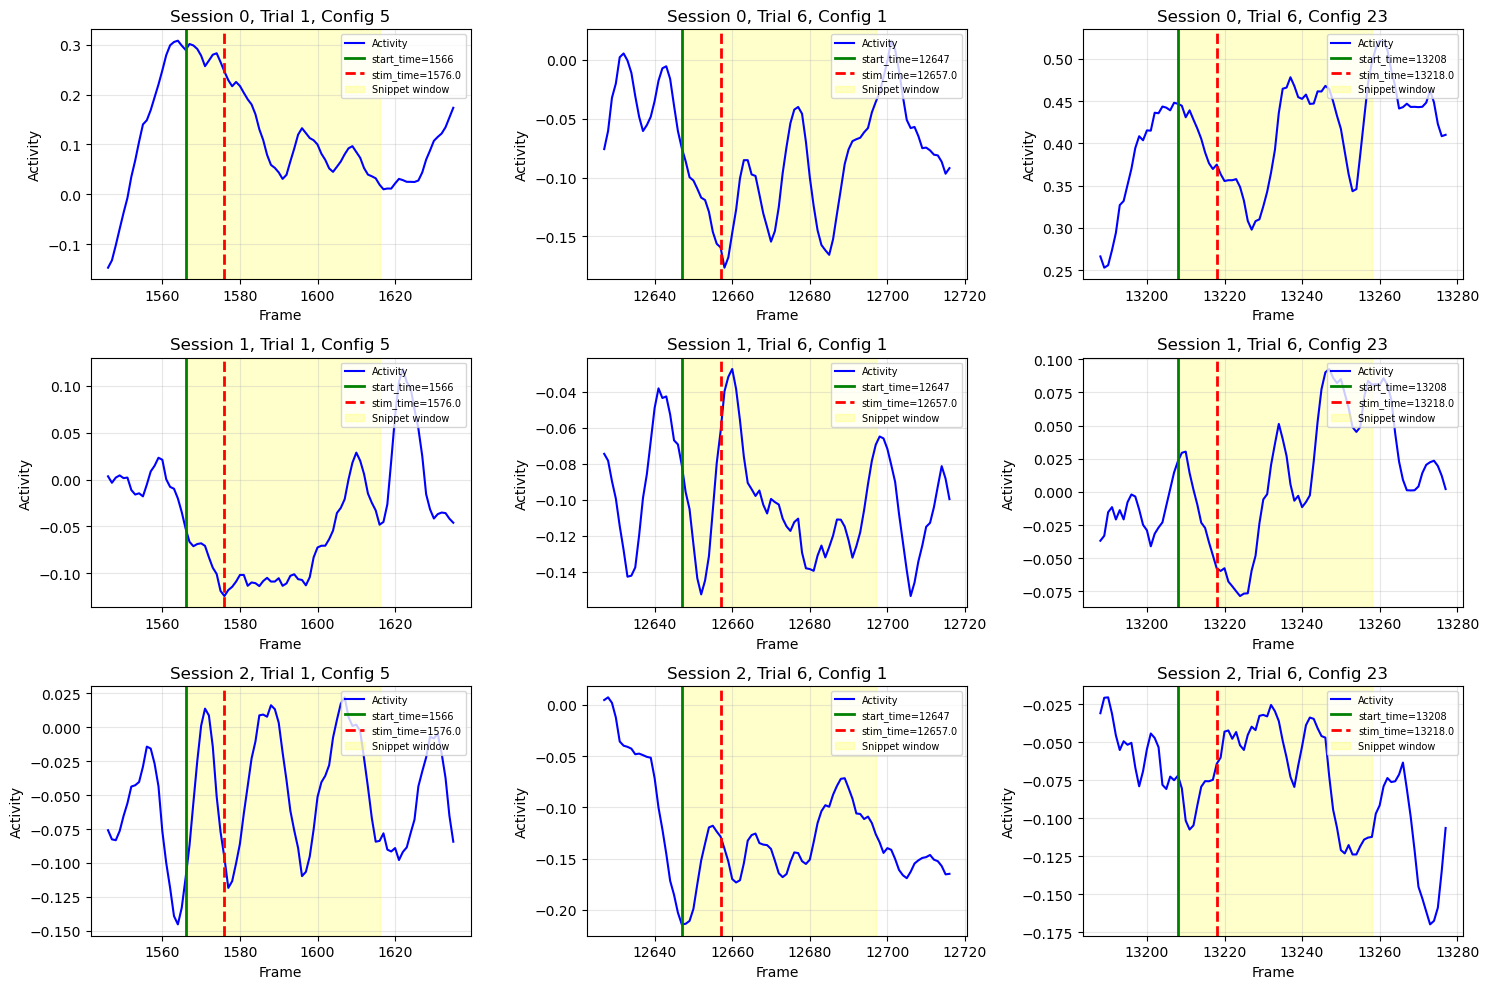

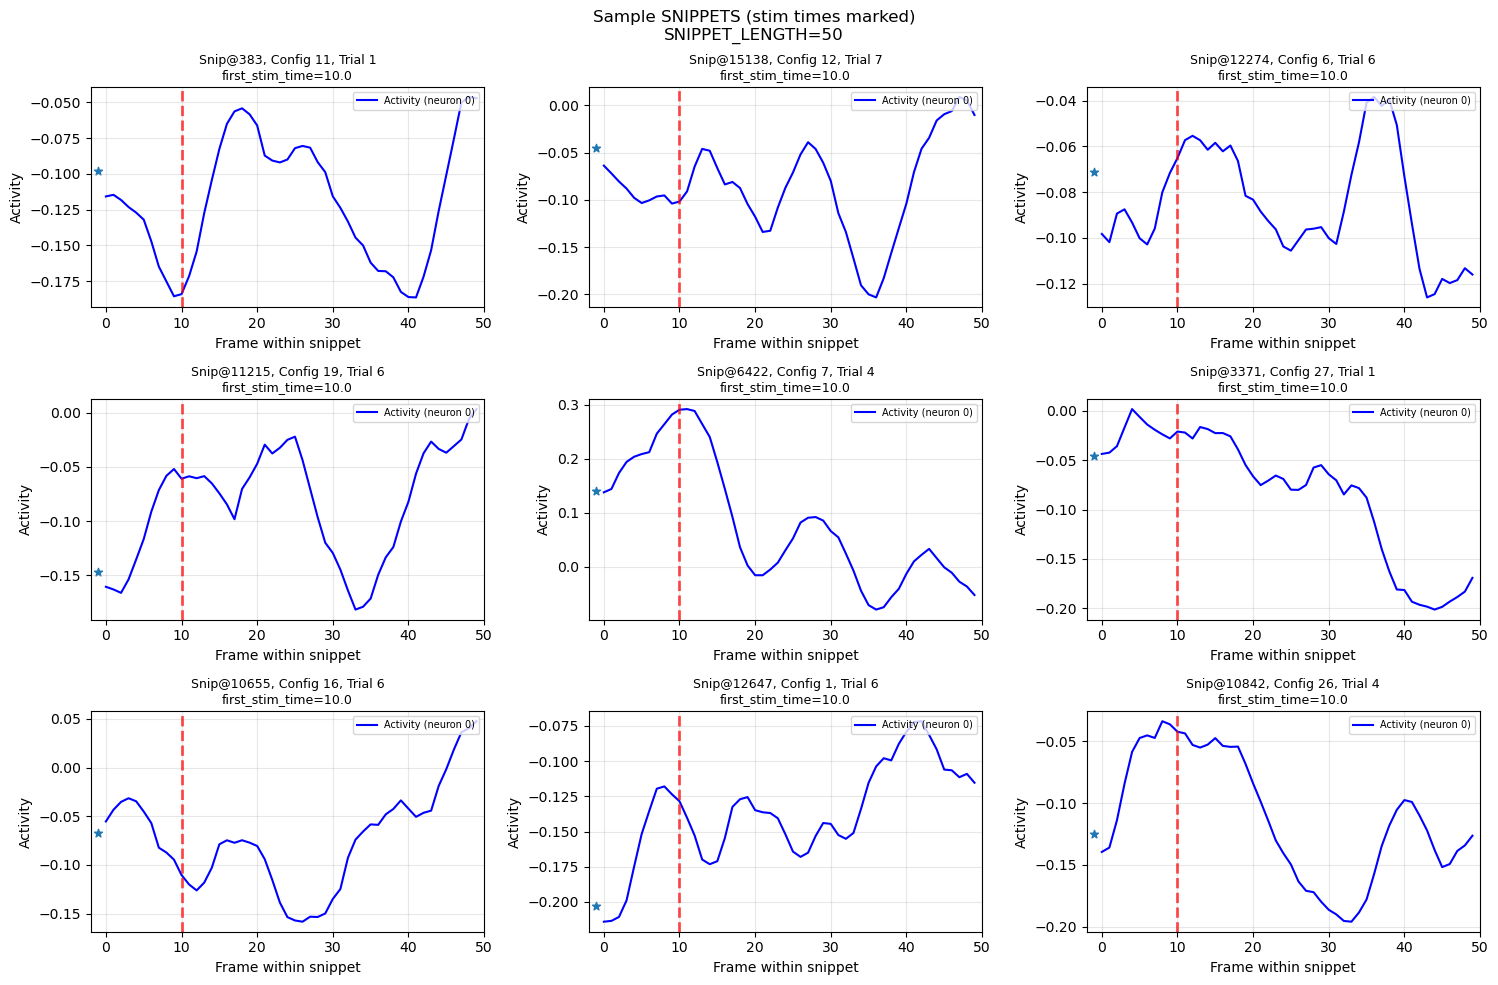

In [69]:
from viz import show_trials_snippets_sample

# Print summary for debugging
print("\n=== Trial vs Snippet Alignment Summary ===")
print(f"STIM_DELAY = {STIM_DELAY} (frames after trial start when stim occurs)")
print(f"START_OFFSET = {START_OFFSET} (snippet starts this many frames before stim)")
print(f"\nExpected: stim_time = start_time + STIM_DELAY")
print(f"Expected: snippet_start = stim_time - START_OFFSET (when stim_at_t0=True)")
print(f"\nIn snippets with stim_at_t0=True, first_stim_time should be ~0")
print(f"\nTest snippets: {len(test_df)}, unique trials in test: {sorted(test_df['first_trial'].dropna().unique())}")
show_trials_snippets_sample(trials_df, train_df, dfof, SNIPPET_LENGTH, seed=SEED, savepath=new_dir_path)

In [70]:
# Pass target_indices to SeqDataset to select which neurons to predict
# Initial conditions use all FILTER_NEURONS, predictions use only TARGET_NEURONS
train_ds = SeqDataset(df=train_df, target_indices=target_indices)
val_ds = SeqDataset(df=val_df, target_indices=target_indices)
test_ds = SeqDataset(df=test_df, target_indices=target_indices)



# --- prepare datasets using DataFrame-based SeqDataset ---
batch_size = 4
logging.info(f'Batch size: {batch_size}')


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 1, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True)

logging.info("Dataset sizes -> train: %d, val: %d, test: %d",
             len(train_ds), len(val_ds), len(test_ds))
logging.info(f"Target neurons: {TARGET_NEURONS} (indices: {target_indices})")


# --- model, loss, optimizer ---
# Get dimensions from the dataset
sample_stim, _ = train_ds[0]
input_size = sample_stim[0].shape[1]  # n_electrodes
# Note: initial_conds uses all FILTER_NEURONS, but output_size matches TARGET_NEURONS
output_size = train_ds.Y.shape[2]     # n_target_neurons
initial_cond_size = train_ds.initial_conds.shape[1]  # n_filter_neurons

N_UNITS = 32  # hidden state size
LOSS_TYPE = "mse"  # Options: 'mse', 'mae', 'weighted_mae'
LR = 0.001
REGULARIZE = 0

# Create model: initial_cond_size uses all FILTER_NEURONS, output_size uses TARGET_NEURONS
model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size).to(device)
logging.info(f'Model architecture:\n{model}')
logging.info(f'Train input size: {input_size}')
logging.info(f'Initial condition size: {initial_cond_size} (FILTER_NEURONS)')
logging.info(f'Train output size: {output_size} (TARGET_NEURONS)')
logging.info(f'Hidden state size: {N_UNITS}')
logging.info(f'Number of GRU layers: {NUM_LAYERS}')


if LOSS_TYPE == 'mae':
    criterion = nn.MSELoss()
elif LOSS_TYPE == 'mae':
    criterion = nn.L1Loss()
elif LOSS_TYPE == 'weighted_mae':
    from modules import WeightedMAELoss
    # Weighted loss parameters
    STIM_WEIGHT = 5.0   # How much more to weight stim-adjacent frames
    STIM_WINDOW = 15    # Frames after stim to upweight (~0.5 sec at 30Hz)
    WEIGHT_DECAY = 'none'  # 'none', 'linear', or 'exp'
    criterion = WeightedMAELoss(stim_weight=STIM_WEIGHT, window=STIM_WINDOW, decay=WEIGHT_DECAY)
    logging.info(f'Using WeightedMAELoss: stim_weight={STIM_WEIGHT}, window={STIM_WINDOW}, decay={WEIGHT_DECAY}')
else:
    criterion = nn.MSELoss()

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=REGULARIZE)
logging.info(f"Learning rate {LR}")
logging.info(f"Optimizer: {OPTIMIZER}")
logging.info(f"Loss type: {LOSS_TYPE}")
logging.info(f"Regularization coefficient: {REGULARIZE}")

# print (f'Example input: {example_input[0]}, \n\nactivity_initial: {example_input[1]}')


2026-01-09 14:48:50,349 INFO: Batch size: 4
2026-01-09 14:48:50,364 INFO: Dataset sizes -> train: 553, val: 98, test: 93
2026-01-09 14:48:50,365 INFO: Target neurons: {21, 22, 23, 26, 27, 31} (indices: [20, 21, 22, 25, 26, 30])
2026-01-09 14:48:50,379 INFO: Model architecture:
RNNModel(
  (initial_state_projection): Linear(in_features=110, out_features=32, bias=True)
  (rnn): GRU(10, 32, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=6, bias=True)
  )
)
2026-01-09 14:48:50,380 INFO: Train input size: 10
2026-01-09 14:48:50,380 INFO: Initial condition size: 110 (FILTER_NEURONS)
2026-01-09 14:48:50,381 INFO: Train output size: 6 (TARGET_NEURONS)
2026-01-09 14:48:50,382 INFO: Hidden state size: 32
2026-01-09 14:48:50,383 INFO: Number of GRU layers: 1
2026-01-09 14:48:50,384 INFO: Learning rate 0.001
2026-01-09 14:48:50,384 INFO: Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_d

## Visualize train/val/test split across sessions as timelines
###  Goal: verify that test snippets don't temporally overlap with train snippets

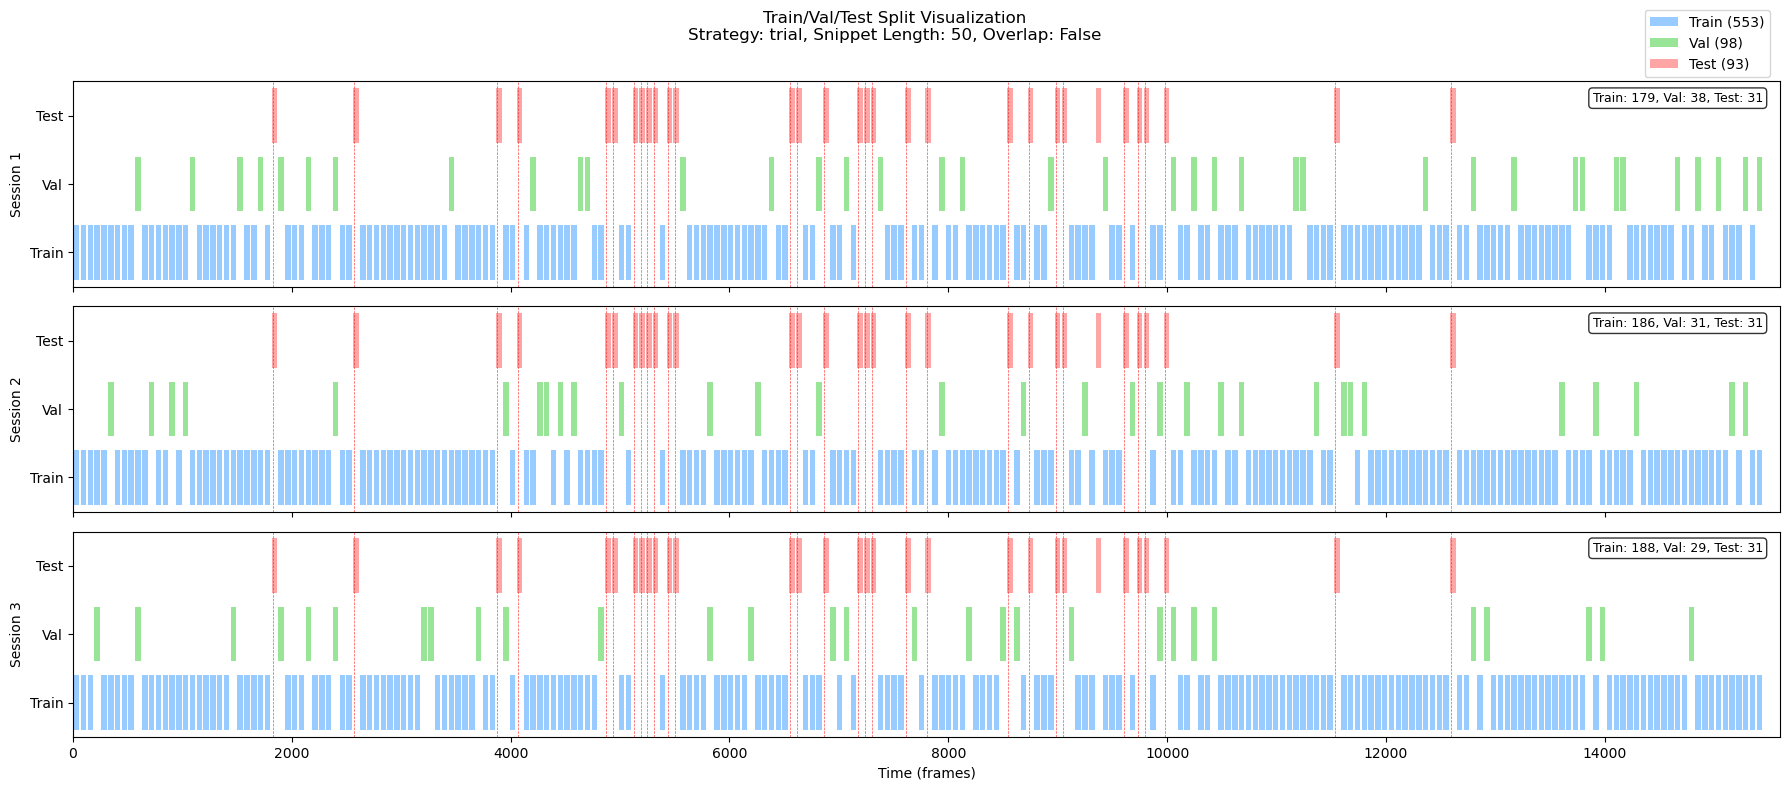


=== Overlap Analysis ===
Session 0: Train frames: 8950, Test frames: 1550, Overlap: 0 frames (0.0% of test)
Session 1: Train frames: 9300, Test frames: 1550, Overlap: 0 frames (0.0% of test)
Session 2: Train frames: 9400, Test frames: 1550, Overlap: 0 frames (0.0% of test)
Visualization saved to: rnn_training/20260109_144817/split_visualization.png


In [71]:
from viz import plot_split_visualization
    
# Call the visualization helper
plot_split_visualization(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    dfof=dfof,
    snippet_length=SNIPPET_LENGTH,
    split_strategy=SPLIT_STRATEGY,
    snippet_overlap=SNIPPET_OVERLAP,
    holdout_trials=HOLDOUT_TRIALS if 'HOLDOUT_TRIALS' in globals() else [],
    trials_df=trials_df,
    output_dir=new_dir_path,
    num_sessions=3,
    figure_size=(18, 8),
    bar_height=0.8,
    dpi=150,
 )

In [72]:
from tqdm.notebook import tqdm
import time
import torch
import logging

def train_with_progress(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    checkpoint_path,
    device,
    device_type,   # e.g. "cuda", "mps", "cpu"
    num_epochs,
    loss_type=None,
    use_amp=True,
    max_grad_norm=1.0,
    early_stop_patience=5,
    min_epochs_before_early_stop=5,
):
    """
    Training loop with:
      - tqdm epoch + batch progress
      - AMP (autocast + GradScaler) when supported
      - optional weighted loss: criterion(outputs, targets, inputs)
      - validation + best-checkpoint save
      - simple early stopping on 'patience' consecutive non-improvements
    """
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}

    # AMP support varies by device; GradScaler is meaningful on CUDA.
    amp_enabled = bool(use_amp) and (device_type in ("cuda",))
    scaler = torch.amp.GradScaler(enabled=amp_enabled)

    def compute_loss(outputs, targets, inputs):
        if loss_type == "weighted_mae":
            return criterion(outputs, targets, inputs)
        return criterion(outputs, targets)

    epoch_pbar = tqdm(range(1, num_epochs + 1), desc="Epochs", unit="ep")

    for epoch in epoch_pbar:
        t0 = time.perf_counter()

        # -------------------- train --------------------
        model.train()
        running_loss = 0.0
        n_train = 0

        for (inputs, activity_initial), targets in tqdm(
            train_loader, desc=f"Epoch {epoch} Train", leave=False, unit="batch"
        ):
            inputs = inputs.to(device, non_blocking=True)
            activity_initial = activity_initial.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=amp_enabled):
                outputs = model((inputs, activity_initial))
                loss = compute_loss(outputs, targets, inputs)

            if amp_enabled:
                scaler.scale(loss).backward()
                # unscale before clipping so clip is in true scale
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                optimizer.step()

            bs = inputs.size(0)
            running_loss += loss.item() * bs
            n_train += bs

        train_loss = running_loss / max(n_train, 1)
        history["train_loss"].append(train_loss)
        logging.info(f"Epoch {epoch} Train loss: {train_loss:.6f}")

        # -------------------- val --------------------
        model.eval()
        val_running = 0.0
        n_val = 0

        with torch.no_grad():
            for (inputs, activity_initial), targets in tqdm(
                val_loader, desc=f"Epoch {epoch} Val", leave=False, unit="batch"
            ):
                inputs = inputs.to(device, non_blocking=True)
                activity_initial = activity_initial.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=amp_enabled):
                    outputs = model((inputs, activity_initial))
                    vloss = compute_loss(outputs, targets, inputs)

                bs = inputs.size(0)
                val_running += vloss.item() * bs
                n_val += bs

        val_loss = val_running / max(n_val, 1)
        history["val_loss"].append(val_loss)
        logging.info(f"Epoch {epoch} Validation loss: {val_loss:.6f}")

        # checkpoint best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            logging.info(f"Saved best model (val={best_val_loss:.6f}) -> {checkpoint_path}")

        # early stopping: no improvement for `patience` consecutive epochs
        if epoch > min_epochs_before_early_stop and len(history["val_loss"]) >= (early_stop_patience + 1):
            recent = history["val_loss"][-(early_stop_patience + 1):]
            no_improve = all(recent[i] >= recent[i - 1] for i in range(1, len(recent)))
            if no_improve:
                logging.info(
                    f"Early stopping: val loss did not improve for {early_stop_patience} consecutive epochs."
                )
                epoch_time = time.perf_counter() - t0
                epoch_pbar.set_postfix(
                    {"train": f"{train_loss:.6f}", "val": f"{val_loss:.6f}", "sec": f"{epoch_time:.2f}"}
                )
                break

        epoch_time = time.perf_counter() - t0
        epoch_pbar.set_postfix(
            {"train": f"{train_loss:.6f}", "val": f"{val_loss:.6f}", "sec": f"{epoch_time:.2f}"}
        )

    return history, best_val_loss

use_amp = True

history, best_val_loss = train_with_progress(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=OPTIMIZER,  
    checkpoint_path=checkpoint_filepath,
    device=device,
    device_type=device_type,   # "cuda" / "mps" / "cpu"
    num_epochs=NUM_EPOCHS,
    loss_type=LOSS_TYPE,
    use_amp=use_amp,
)


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-09 14:49:17,234 INFO: Epoch 1 Train loss: 0.017610


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-09 14:49:17,630 INFO: Epoch 1 Validation loss: 0.017362
2026-01-09 14:49:17,636 INFO: Saved best model (val=0.017362) -> rnn_training/20260109_144817/best_model.pth


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:49:22,426 INFO: Epoch 2 Train loss: 0.014308


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:49:22,610 INFO: Epoch 2 Validation loss: 0.014181
2026-01-09 14:49:22,615 INFO: Saved best model (val=0.014181) -> rnn_training/20260109_144817/best_model.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:49:27,548 INFO: Epoch 3 Train loss: 0.012121


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:49:27,781 INFO: Epoch 3 Validation loss: 0.014984


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:49:32,990 INFO: Epoch 4 Train loss: 0.010963


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:49:33,386 INFO: Epoch 4 Validation loss: 0.013401
2026-01-09 14:49:33,392 INFO: Saved best model (val=0.013401) -> rnn_training/20260109_144817/best_model.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:49:38,176 INFO: Epoch 5 Train loss: 0.010478


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:49:38,364 INFO: Epoch 5 Validation loss: 0.012715
2026-01-09 14:49:38,367 INFO: Saved best model (val=0.012715) -> rnn_training/20260109_144817/best_model.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:49:43,333 INFO: Epoch 6 Train loss: 0.009898


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:49:43,525 INFO: Epoch 6 Validation loss: 0.012204
2026-01-09 14:49:43,529 INFO: Saved best model (val=0.012204) -> rnn_training/20260109_144817/best_model.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:49:48,407 INFO: Epoch 7 Train loss: 0.009638


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:49:48,734 INFO: Epoch 7 Validation loss: 0.012282


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:49:53,593 INFO: Epoch 8 Train loss: 0.009324


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:49:53,833 INFO: Epoch 8 Validation loss: 0.011548
2026-01-09 14:49:53,838 INFO: Saved best model (val=0.011548) -> rnn_training/20260109_144817/best_model.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:49:58,816 INFO: Epoch 9 Train loss: 0.009006


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:49:59,007 INFO: Epoch 9 Validation loss: 0.011223
2026-01-09 14:49:59,010 INFO: Saved best model (val=0.011223) -> rnn_training/20260109_144817/best_model.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:04,024 INFO: Epoch 10 Train loss: 0.008673


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:04,348 INFO: Epoch 10 Validation loss: 0.011483


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:09,268 INFO: Epoch 11 Train loss: 0.008394


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:09,456 INFO: Epoch 11 Validation loss: 0.011236


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:14,374 INFO: Epoch 12 Train loss: 0.008145


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:14,568 INFO: Epoch 12 Validation loss: 0.011812


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:19,457 INFO: Epoch 13 Train loss: 0.008003


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:19,652 INFO: Epoch 13 Validation loss: 0.011384


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:24,474 INFO: Epoch 14 Train loss: 0.007847


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:24,783 INFO: Epoch 14 Validation loss: 0.011069
2026-01-09 14:50:24,789 INFO: Saved best model (val=0.011069) -> rnn_training/20260109_144817/best_model.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:29,526 INFO: Epoch 15 Train loss: 0.007668


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:29,723 INFO: Epoch 15 Validation loss: 0.011044
2026-01-09 14:50:29,727 INFO: Saved best model (val=0.011044) -> rnn_training/20260109_144817/best_model.pth


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:34,549 INFO: Epoch 16 Train loss: 0.007567


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:34,738 INFO: Epoch 16 Validation loss: 0.011419


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:39,511 INFO: Epoch 17 Train loss: 0.007415


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:39,830 INFO: Epoch 17 Validation loss: 0.011078


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:44,787 INFO: Epoch 18 Train loss: 0.007385


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:44,981 INFO: Epoch 18 Validation loss: 0.011305


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:49,666 INFO: Epoch 19 Train loss: 0.007271


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:49,855 INFO: Epoch 19 Validation loss: 0.011515


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:54,713 INFO: Epoch 20 Train loss: 0.007113


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:50:55,061 INFO: Epoch 20 Validation loss: 0.011165


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:50:59,971 INFO: Epoch 21 Train loss: 0.007046


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:00,159 INFO: Epoch 21 Validation loss: 0.011044
2026-01-09 14:51:00,163 INFO: Saved best model (val=0.011044) -> rnn_training/20260109_144817/best_model.pth


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:04,958 INFO: Epoch 22 Train loss: 0.007021


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:05,149 INFO: Epoch 22 Validation loss: 0.011500


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:09,971 INFO: Epoch 23 Train loss: 0.006904


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:10,280 INFO: Epoch 23 Validation loss: 0.011368


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:15,855 INFO: Epoch 24 Train loss: 0.006758


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:16,050 INFO: Epoch 24 Validation loss: 0.011209


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:20,705 INFO: Epoch 25 Train loss: 0.006940


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:20,929 INFO: Epoch 25 Validation loss: 0.011029
2026-01-09 14:51:20,945 INFO: Saved best model (val=0.011029) -> rnn_training/20260109_144817/best_model.pth


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:26,304 INFO: Epoch 26 Train loss: 0.006694


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:26,498 INFO: Epoch 26 Validation loss: 0.011516


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:31,257 INFO: Epoch 27 Train loss: 0.006677


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:31,449 INFO: Epoch 27 Validation loss: 0.011489


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:36,311 INFO: Epoch 28 Train loss: 0.006615


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:36,678 INFO: Epoch 28 Validation loss: 0.011588


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:41,274 INFO: Epoch 29 Train loss: 0.006570


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:41,459 INFO: Epoch 29 Validation loss: 0.011364


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 14:51:45,732 INFO: Epoch 30 Train loss: 0.006366


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 14:51:45,914 INFO: Epoch 30 Validation loss: 0.011539


## Calculate test-error

In [82]:
from utils import get_inputs_outputs_targets, get_model_error
from utils import *


model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()



test_loss = get_model_error(model, test_loader, criterion, device, LOSS_TYPE)
logging.info(f'Test Loss: {test_loss:.6f}')
plot_inputs, plot_initconds, plot_targets, plot_outputs = get_inputs_outputs_targets(model, test_loader, device)


2026-01-09 14:59:48,181 INFO: Test Loss: 0.008635


In [ ]:
# ==================== CROSS-VALIDATION ACROSS SPLIT STRATEGY ====================
# This cell performs K-fold cross-validation by iterating over elements of the
# chosen SPLIT_STRATEGY. For each fold, one element is held out as test.

import os
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import logging

from utils import create_split_dfs, get_model_error
from modules import RNNModel, SeqDataset

# ----- Hyperparameters (collected in dict for reproducibility) -----
CV_HPARAMS = {
    'split_strategy': SPLIT_STRATEGY,
    'snippet_length': SNIPPET_LENGTH,
    'snippet_overlap': SNIPPET_OVERLAP,
    'snippet_stride': SNIPPET_STRIDE,
    'val_size': VAL_SIZE,
    'seed': SEED,
    'batch_size': batch_size,
    'n_units': N_UNITS,
    'num_layers': NUM_LAYERS,
    'loss_type': LOSS_TYPE,
    'lr': LR,
    'regularize': REGULARIZE,
    'num_epochs': NUM_EPOCHS,
    'early_stop_patience': 5,
    'use_amp': use_amp,
}

logging.info(f"=== Cross-Validation Hyperparameters ===")
for k, v in CV_HPARAMS.items():
    logging.info(f"  {k}: {v}")

# ----- Determine fold elements based on split strategy -----
if CV_HPARAMS['split_strategy'] == 'trial':
    fold_elements = list(range(8))  # trials 0-7
    holdout_key = 'holdout_trials'
elif CV_HPARAMS['split_strategy'] == 'session':
    fold_elements = list(range(3))  # sessions 0-2
    holdout_key = 'holdout_sessions'
elif CV_HPARAMS['split_strategy'] == 'config':
    fold_elements = list(range(1, 32))  # configs 1-31
    holdout_key = 'holdout_configs'
elif CV_HPARAMS['split_strategy'] == 'electrode':
    fold_elements = list(range(10)) + [None]  # electrodes 0-9 + None (config 31)
    holdout_key = 'holdout_electrodes'
elif CV_HPARAMS['split_strategy'] == 'current':
    fold_elements = [0, 3, 4, 5]  # current levels (0 = no stim)
    holdout_key = 'holdout_currents'
else:
    raise ValueError(f"Cross-validation not supported for strategy: {CV_HPARAMS['split_strategy']}")

n_folds = len(fold_elements)
logging.info(f"Running {n_folds}-fold CV on '{CV_HPARAMS['split_strategy']}' with elements: {fold_elements}")

# ----- Cross-validation loop -----
cv_results = []

for fold_idx, holdout_element in enumerate(tqdm(fold_elements, desc="CV Folds")):
    logging.info(f"\n{'='*60}")
    logging.info(f"FOLD {fold_idx + 1}/{n_folds}: Holding out {CV_HPARAMS['split_strategy']}={holdout_element}")
    logging.info(f"{'='*60}")
    
    # Build holdout kwargs: only set the relevant holdout, others empty
    holdout_kwargs = {
        'holdout_sessions': [],
        'holdout_trials': [],
        'holdout_configs': [],
        'holdout_electrodes': [],
        'holdout_currents': [],
    }
    holdout_kwargs[holdout_key] = [holdout_element]
    
    # Create train/val/test splits for this fold
    fold_train_df, fold_val_df, fold_test_df = create_split_dfs(
        split_strategy=CV_HPARAMS['split_strategy'],
        valid_df=valid_df.copy(),
        trials_df=trials_df,
        sessions=sessions,
        snippet_length=CV_HPARAMS['snippet_length'],
        val_size=CV_HPARAMS['val_size'],
        seed=CV_HPARAMS['seed'],
        **holdout_kwargs
    )
    
    # Skip fold if test set is empty
    if len(fold_test_df) == 0:
        logging.warning(f"Fold {fold_idx + 1}: Empty test set for holdout={holdout_element}, skipping.")
        continue
    
    logging.info(f"Fold {fold_idx + 1} sizes: train={len(fold_train_df)}, val={len(fold_val_df)}, test={len(fold_test_df)}")
    
    # Create datasets and loaders
    fold_train_ds = SeqDataset(df=fold_train_df, target_indices=target_indices)
    fold_val_ds = SeqDataset(df=fold_val_df, target_indices=target_indices)
    fold_test_ds = SeqDataset(df=fold_test_df, target_indices=target_indices)
    
    fold_train_loader = DataLoader(fold_train_ds, batch_size=CV_HPARAMS['batch_size'], 
                                   shuffle=True, num_workers=max(1, os.cpu_count() - 1), pin_memory=True)
    fold_val_loader = DataLoader(fold_val_ds, batch_size=CV_HPARAMS['batch_size'], 
                                 shuffle=False, pin_memory=True)
    fold_test_loader = DataLoader(fold_test_ds, batch_size=CV_HPARAMS['batch_size'], 
                                  shuffle=False, pin_memory=True)
    
    # Initialize fresh model for this fold
    fold_model = RNNModel(
        input_size=input_size, 
        units=CV_HPARAMS['n_units'], 
        output_size=output_size,
        num_layers=CV_HPARAMS['num_layers'], 
        initial_cond_size=initial_cond_size
    ).to(device)
    
    # Loss and optimizer
    if CV_HPARAMS['loss_type'] == 'mae':
        fold_criterion = nn.L1Loss()
    elif CV_HPARAMS['loss_type'] == 'weighted_mae':
        from modules import WeightedMAELoss
        fold_criterion = WeightedMAELoss(stim_weight=5.0, window=15, decay='none')
    else:
        fold_criterion = nn.MSELoss()
    
    fold_optimizer = torch.optim.Adam(fold_model.parameters(), lr=CV_HPARAMS['lr'], 
                                       weight_decay=CV_HPARAMS['regularize'])
    
    # Checkpoint path for this fold
    fold_checkpoint = os.path.join(new_dir_path, f"cv_fold_{fold_idx}_best.pth")
    
    # Train this fold (using the existing train_with_progress function)
    fold_history, fold_best_val = train_with_progress(
        model=fold_model,
        train_loader=fold_train_loader,
        val_loader=fold_val_loader,
        criterion=fold_criterion,
        optimizer=fold_optimizer,
        checkpoint_path=fold_checkpoint,
        device=device,
        device_type=device_type,
        num_epochs=CV_HPARAMS['num_epochs'],
        loss_type=CV_HPARAMS['loss_type'],
        use_amp=CV_HPARAMS['use_amp'],
        early_stop_patience=CV_HPARAMS['early_stop_patience'],
    )
    
    # Load best model and evaluate on test
    fold_model.load_state_dict(torch.load(fold_checkpoint, map_location=device))
    fold_model.eval()
    
    fold_test_loss = get_model_error(fold_model, fold_test_loader, fold_criterion, device, CV_HPARAMS['loss_type'])
    
    logging.info(f"Fold {fold_idx + 1} | Holdout={holdout_element} | Best Val={fold_best_val:.6f} | Test={fold_test_loss:.6f}")
    
    cv_results.append({
        'fold': fold_idx + 1,
        'holdout_element': holdout_element,
        'train_size': len(fold_train_df),
        'val_size': len(fold_val_df),
        'test_size': len(fold_test_df),
        'best_val_loss': fold_best_val,
        'test_loss': fold_test_loss,
        'history': fold_history,
    })

# ----- Aggregate and report CV results -----
print("\n" + "="*70)
print(f"CROSS-VALIDATION RESULTS ({CV_HPARAMS['split_strategy']} strategy, {len(cv_results)} folds)")
print("="*70)

test_losses = [r['test_loss'] for r in cv_results]
val_losses = [r['best_val_loss'] for r in cv_results]

for r in cv_results:
    print(f"  Fold {r['fold']:2d} | Holdout={str(r['holdout_element']):>4s} | "
          f"Val={r['best_val_loss']:.6f} | Test={r['test_loss']:.6f} | "
          f"n_test={r['test_size']}")

print("-"*70)
cv_mean_test = np.mean(test_losses)
cv_std_test = np.std(test_losses)
cv_mean_val = np.mean(val_losses)
cv_std_val = np.std(val_losses)

print(f"  MEAN Test Loss: {cv_mean_test:.6f} ± {cv_std_test:.6f}")
print(f"  MEAN Val Loss:  {cv_mean_val:.6f} ± {cv_std_val:.6f}")
print("="*70)

logging.info(f"CV Complete: Mean Test Loss = {cv_mean_test:.6f} ± {cv_std_test:.6f}")

# Save CV results summary
import json
cv_summary = {
    'hparams': CV_HPARAMS,
    'fold_results': [{k: v for k, v in r.items() if k != 'history'} for r in cv_results],
    'mean_test_loss': cv_mean_test,
    'std_test_loss': cv_std_test,
    'mean_val_loss': cv_mean_val,
    'std_val_loss': cv_std_val,
}
cv_summary_path = os.path.join(new_dir_path, 'cv_summary.json')
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"CV summary saved to {cv_summary_path}")

2026-01-09 15:20:13,117 INFO: === Cross-Validation Hyperparameters ===
2026-01-09 15:20:13,120 INFO:   split_strategy: trial
2026-01-09 15:20:13,120 INFO:   snippet_length: 50
2026-01-09 15:20:13,121 INFO:   snippet_overlap: False
2026-01-09 15:20:13,122 INFO:   snippet_stride: 1
2026-01-09 15:20:13,123 INFO:   val_size: 0.15
2026-01-09 15:20:13,124 INFO:   seed: 42
2026-01-09 15:20:13,125 INFO:   batch_size: 4
2026-01-09 15:20:13,125 INFO:   n_units: 32
2026-01-09 15:20:13,126 INFO:   num_layers: 1
2026-01-09 15:20:13,126 INFO:   loss_type: mse
2026-01-09 15:20:13,127 INFO:   lr: 0.001
2026-01-09 15:20:13,128 INFO:   regularize: 0
2026-01-09 15:20:13,128 INFO:   num_epochs: 30
2026-01-09 15:20:13,129 INFO:   early_stop_patience: 5
2026-01-09 15:20:13,129 INFO:   use_amp: True
2026-01-09 15:20:13,131 INFO: Running 8-fold CV on 'trial' with elements: [0, 1, 2, 3, 4, 5, 6, 7]


CV Folds:   0%|          | 0/8 [00:00<?, ?it/s]

2026-01-09 15:20:13,149 INFO: 
2026-01-09 15:20:13,150 INFO: FOLD 1/8: Holding out trial=0
2026-01-09 15:20:13,152 INFO: ============================================================
2026-01-09 15:20:13,183 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-09 15:20:13,187 INFO: === Split Summary (trial) ===
2026-01-09 15:20:13,188 INFO: Train: 553 samples (74.3%)
2026-01-09 15:20:13,189 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-09 15:20:13,189 INFO: Val: 98 samples (13.2%)
2026-01-09 15:20:13,189 INFO: Test: 93 samples (12.5%)
2026-01-09 15:20:13,190 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-09 15:20:13,190 INFO: Fold 1 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-09 15:20:18,774 INFO: Epoch 1 Train loss: 0.017113


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:20:18,971 INFO: Epoch 1 Validation loss: 0.014136
2026-01-09 15:20:18,977 INFO: Saved best model (val=0.014136) -> rnn_training/20260109_122822/cv_fold_0_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:20:24,230 INFO: Epoch 2 Train loss: 0.014271


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:20:24,427 INFO: Epoch 2 Validation loss: 0.010918
2026-01-09 15:20:24,431 INFO: Saved best model (val=0.010918) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:20:29,894 INFO: Epoch 3 Train loss: 0.012023


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:20:30,122 INFO: Epoch 3 Validation loss: 0.010508
2026-01-09 15:20:30,126 INFO: Saved best model (val=0.010508) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:20:35,664 INFO: Epoch 4 Train loss: 0.011477


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:20:35,862 INFO: Epoch 4 Validation loss: 0.010062
2026-01-09 15:20:35,868 INFO: Saved best model (val=0.010062) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:20:40,858 INFO: Epoch 5 Train loss: 0.010754


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:20:41,206 INFO: Epoch 5 Validation loss: 0.009309
2026-01-09 15:20:41,211 INFO: Saved best model (val=0.009309) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:20:46,082 INFO: Epoch 6 Train loss: 0.010279


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:20:46,280 INFO: Epoch 6 Validation loss: 0.009343


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:20:51,387 INFO: Epoch 7 Train loss: 0.009666


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:20:51,581 INFO: Epoch 7 Validation loss: 0.008844
2026-01-09 15:20:51,585 INFO: Saved best model (val=0.008844) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:20:56,810 INFO: Epoch 8 Train loss: 0.009174


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:20:56,998 INFO: Epoch 8 Validation loss: 0.008754
2026-01-09 15:20:57,002 INFO: Saved best model (val=0.008754) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:02,137 INFO: Epoch 9 Train loss: 0.008887


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:02,334 INFO: Epoch 9 Validation loss: 0.008437
2026-01-09 15:21:02,338 INFO: Saved best model (val=0.008437) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:08,496 INFO: Epoch 10 Train loss: 0.008678


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:08,830 INFO: Epoch 10 Validation loss: 0.008226
2026-01-09 15:21:08,835 INFO: Saved best model (val=0.008226) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:15,136 INFO: Epoch 11 Train loss: 0.008567


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:15,326 INFO: Epoch 11 Validation loss: 0.008349


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:20,163 INFO: Epoch 12 Train loss: 0.008319


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:20,352 INFO: Epoch 12 Validation loss: 0.008936


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:24,989 INFO: Epoch 13 Train loss: 0.008101


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:25,177 INFO: Epoch 13 Validation loss: 0.008253


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:30,167 INFO: Epoch 14 Train loss: 0.008069


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:30,350 INFO: Epoch 14 Validation loss: 0.008206
2026-01-09 15:21:30,354 INFO: Saved best model (val=0.008206) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:35,074 INFO: Epoch 15 Train loss: 0.007790


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:35,264 INFO: Epoch 15 Validation loss: 0.008006
2026-01-09 15:21:35,268 INFO: Saved best model (val=0.008006) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:40,362 INFO: Epoch 16 Train loss: 0.007699


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:40,552 INFO: Epoch 16 Validation loss: 0.008001
2026-01-09 15:21:40,556 INFO: Saved best model (val=0.008001) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:45,326 INFO: Epoch 17 Train loss: 0.007609


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:45,512 INFO: Epoch 17 Validation loss: 0.007825
2026-01-09 15:21:45,516 INFO: Saved best model (val=0.007825) -> rnn_training/20260109_122822/cv_fold_0_best.pth


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:50,188 INFO: Epoch 18 Train loss: 0.007404


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:50,471 INFO: Epoch 18 Validation loss: 0.008145


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:21:55,268 INFO: Epoch 19 Train loss: 0.007313


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:21:55,463 INFO: Epoch 19 Validation loss: 0.008201


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:00,296 INFO: Epoch 20 Train loss: 0.007140


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:00,490 INFO: Epoch 20 Validation loss: 0.008408


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:06,982 INFO: Epoch 21 Train loss: 0.007095


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:07,201 INFO: Epoch 21 Validation loss: 0.008047


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:12,690 INFO: Epoch 22 Train loss: 0.007093


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:12,940 INFO: Epoch 22 Validation loss: 0.008107


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:19,651 INFO: Epoch 23 Train loss: 0.006936


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:19,851 INFO: Epoch 23 Validation loss: 0.008507


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:24,654 INFO: Epoch 24 Train loss: 0.006920


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:24,844 INFO: Epoch 24 Validation loss: 0.008359


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:29,631 INFO: Epoch 25 Train loss: 0.006820


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:29,825 INFO: Epoch 25 Validation loss: 0.007928


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:34,745 INFO: Epoch 26 Train loss: 0.006736


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:35,121 INFO: Epoch 26 Validation loss: 0.008464


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:39,826 INFO: Epoch 27 Train loss: 0.006748


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:40,019 INFO: Epoch 27 Validation loss: 0.009016


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-09 15:22:44,884 INFO: Epoch 28 Train loss: 0.006643


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-09 15:22:45,077 INFO: Epoch 28 Validation loss: 0.008171


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

## Save correlation of predicted vs real for each time series in test data

In [ ]:
# Create mapping from neuron number to output index (model output only has TARGET_NEURONS)
neuron_to_output_idx = {n: i for i, n in enumerate(TARGET_NEURONS)}

os.makedirs(os.path.join(f'rnn_training/{DATETIME_STAMP}/test_sample_corr/'), exist_ok=True)
plt.figure(figsize=(10, 5))

# Track correlations for logging - use dict to accumulate per ROI across all good_pairs instances
all_correlations = []
correlations_by_roi = {}  # roi -> list of correlations

# Only plot neurons that are in TARGET_NEURONS
for config, roi in good_pairs:
    # Skip if this neuron is not in TARGET_NEURONS
    if roi not in TARGET_NEURONS:
        print(f"Skipping ROI {roi} (not in TARGET_NEURONS={TARGET_NEURONS})")
        continue
    
    # Initialize list for this ROI if not already present
    if roi not in correlations_by_roi:
        correlations_by_roi[roi] = []
    
    output_idx = neuron_to_output_idx[roi]
    print(f"Plotting ROI {roi} (config {config}, output index {output_idx}) prediction over test samples")
    
    # randomly choose 10 samples for each pair in good pairs
    for test_sample in np.random.choice(np.arange(plot_targets.shape[0]), min(10, plot_targets.shape[0]), replace=False):
        plt.figure(figsize=(10, 5))
        input = plot_inputs[test_sample, :, :].squeeze()
        stim_times = np.nonzero(input)[0]
        electrodes = np.nonzero(input)[1]
        for i, time in enumerate(stim_times):
            current = input[stim_times[i], electrodes[i]]
            if current == 3:
                plt.axvline(x=time, color='r', linestyle='--')
            elif current == 4:
                plt.axvline(x=time, color='b', linestyle='--')
            elif current == 5:
                plt.axvline(x=time, color='g', linestyle='--')
            else:
                pass
        plt.title(f"ROI {roi}, test sample {test_sample}")
        ax = plt.gca()
        corr_value = np.corrcoef(plot_outputs[test_sample, :, output_idx],
                                 plot_targets[test_sample, :, output_idx])[0, 1]
        all_correlations.append(corr_value)
        correlations_by_roi[roi].append(corr_value)
        ax.text(0.98, 0.98, f"corr={corr_value:.3f}", transform=ax.transAxes,
                ha='right', va='top')

        plt.plot(plot_outputs[test_sample, :, output_idx], 'blue', linewidth=1.0, label="predicted")
        plt.plot(plot_targets[test_sample, :, output_idx], 'orange', linewidth=1.0, label="ground truth")
        plt.ylim(-0.5, 1.0)
        plt.yticks([-0.5, 0, 0.5, 1.0])
        plt.grid()
        plt.legend()
        plt.savefig(os.path.join(f'rnn_training/{DATETIME_STAMP}/test_sample_corr', f"{roi}_{config}_{test_sample}.png"))
        plt.close()

# Log average correlation for each unique ROI (accumulated across all good_pairs instances)
for roi, corrs in correlations_by_roi.items():
    roi_avg_corr = np.nanmean(corrs)
    logging.info(f"ROI {roi}: avg correlation = {roi_avg_corr:.4f} (n={len(corrs)} samples across all good_pairs)")

# Log overall average correlation
overall_avg_corr = np.nanmean(all_correlations)
logging.info(f"Overall avg correlation across all good pairs: {overall_avg_corr:.4f} (n={len(all_correlations)} samples)")

# Random overlay of timeseries for each roy overlaid

{21, 22, 23, 26, 27, 31}


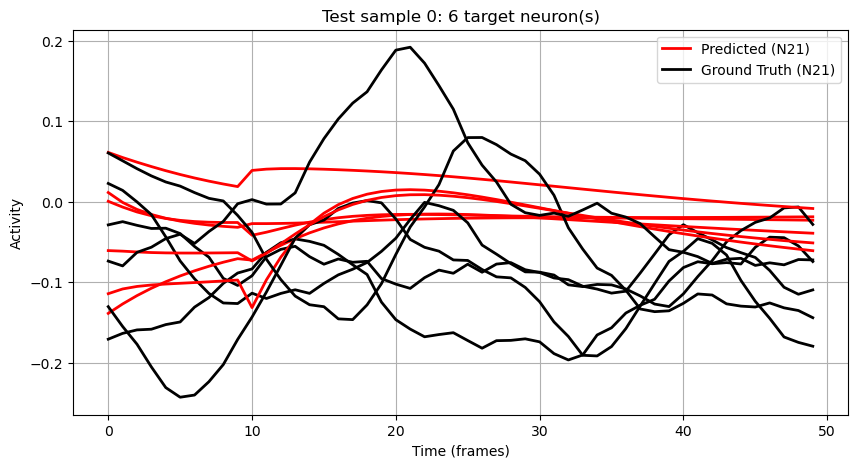

In [86]:
from viz import random_timeseries_overlay
print (TARGET_NEURONS)
random_timeseries_overlay(plot_outputs, plot_targets, target_neurons=TARGET_NEURONS)

## Loss over Epochs Plot

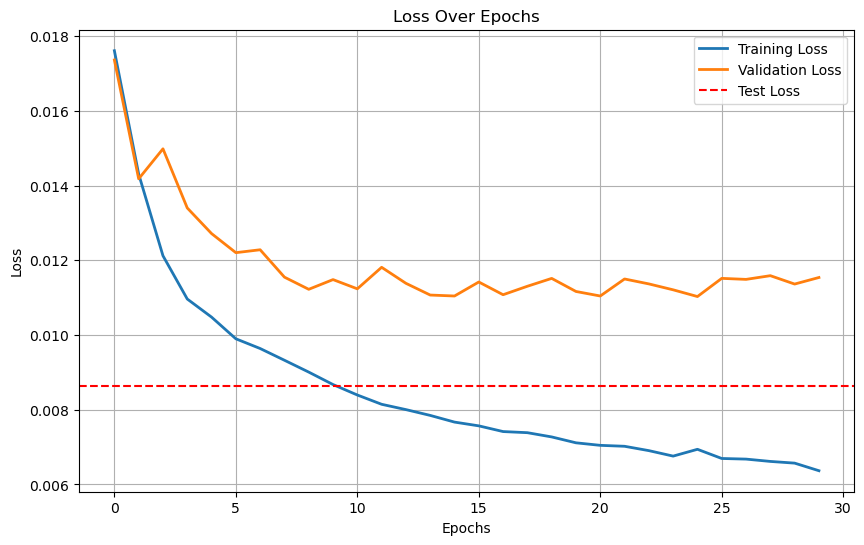

In [87]:
from viz import plot_losses
plot_losses(history, test_loss, savepath=new_dir_path)

## PSTHs like Yuxuans


In [ ]:
# PSTHs like Yuxuans
# For each config, choose neurons of interest and plot PSTHs neurons on rows, session on columns 
# use test_df DataFrame as reference 

import json
import matplotlib.cm as cm

# Load neurons of interest from JSON config file
with open('psth_neurons_config.json', 'r') as f:
    psth_config = json.load(f)

neurons_by_config = psth_config['neurons_by_config']
default_neurons = psth_config['default_neurons']

# OFFSET: time within snippet when stim should occur (0 = stim at start, 10 = see 10 frames before stim)
STIM_OFFSET = 0 # frames before stim to show in plot
POST_STIM_FRAMES = 50  # frames after stim to show for ground truth

# Option: use all data (with session columns) or just test data
USE_ALL_DATA = True  # If True, plot all data with 3 session columns; if False, use only test data

# Alpha settings: low for train, high for test
TRAIN_ALPHA = 0.3
TEST_ALPHA = 0.9

model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()

# Create psths directory if it doesn't exist
os.makedirs(f'rnn_training/{DATETIME_STAMP}/psths', exist_ok=True)

# Get train indices for checking if a sample is in training set
train_indices = set(train_df.index)
test_indices = set(test_df.index)

# Create neuron index mapping: original neuron number -> index in filtered dfof
# If FILTER_NEURONS is None, identity mapping; otherwise map to filtered indices
if FILTER_NEURONS is not None:
    neuron_to_dfof_idx = {n: i for i, n in enumerate(FILTER_NEURONS)}
else:
    neuron_to_dfof_idx = {n: n - 1 for n in range(1, dfof[0].shape[1] + 1)}  # 1-indexed to 0-indexed

# Create mapping for model output: neuron number -> index in TARGET_NEURONS
# Model output only has TARGET_NEURONS columns
neuron_to_output_idx = {n: i for i, n in enumerate(TARGET_NEURONS)}

# Choose which DataFrame to use
if USE_ALL_DATA:
    # Use valid_df which contains all valid snippets
    source_df = valid_df
    n_sessions = 3
else:
    source_df = test_df
    n_sessions = 1

# Total frames to display: STIM_OFFSET before + POST_STIM_FRAMES after
TOTAL_DISPLAY_FRAMES = STIM_OFFSET + POST_STIM_FRAMES

# Determine which configs to iterate over
if FILTER_CONFIGS is not None:
    configs_to_plot = FILTER_CONFIGS
else:
    configs_to_plot = list(range(1, 32))

for config in configs_to_plot:
    # Get neurons of interest for this config from JSON, fall back to default if empty
    neurons_of_interest = neurons_by_config.get(str(config), default_neurons)
    if len(neurons_of_interest) == 0:
        neurons_of_interest = default_neurons
    
    # Only plot neurons that are in TARGET_NEURONS (since model only predicts those)
    neurons_of_interest = [n for n in neurons_of_interest if n in TARGET_NEURONS]
    if len(neurons_of_interest) == 0:
        # Fall back to all target neurons if none from config match
        neurons_of_interest = TARGET_NEURONS
    
    # Filter for snippets where stim occurs at the OFFSET time for this config
    matching_df = source_df[(source_df['first_config'] == config) & (source_df['first_stim_time'] == STIM_OFFSET)]
    
    logging.info(f'Config {config} has {len(matching_df)} matching snippets (stim at t={STIM_OFFSET}), neurons: {neurons_of_interest}')
    if len(matching_df) == 0:
        logging.info(f'No matching snippets for config {config} with stim at offset {STIM_OFFSET}, skipping.')
        continue
    
    # Create figure: rows = neurons, columns = sessions (if USE_ALL_DATA) or 1 column
    # Square subplots
    subplot_size = 4  # inches per subplot (square)
    if USE_ALL_DATA:
        f, ax = plt.subplots(len(neurons_of_interest), n_sessions, 
                             figsize=(subplot_size*n_sessions, subplot_size*len(neurons_of_interest)), 
                             sharex=True, sharey=True, squeeze=False)
    else:
        f, ax = plt.subplots(len(neurons_of_interest), 1, 
                             figsize=(subplot_size, subplot_size*len(neurons_of_interest)), 
                             sharex=True, sharey=True, squeeze=False)
    
    # Time axis for prediction (limited by SNIPPET_LENGTH)
    pred_time_axis = np.arange(SNIPPET_LENGTH) - STIM_OFFSET
    
    # Time axis for ground truth (full 60 frames after stim)
    gt_time_axis = np.arange(TOTAL_DISPLAY_FRAMES) - STIM_OFFSET
    
    # Color mapping for current levels (for stim lines)
    current_colors = {3: 'red', 4: 'blue', 5: 'green'}
    
    # plot predictions for the config and neurons of interest
    for row_idx, neuron in enumerate(neurons_of_interest):
        # Get the index in the dfof array (for ground truth)
        dfof_idx = neuron_to_dfof_idx[neuron]
        # Get the index in the model output (for predictions)
        output_idx = neuron_to_output_idx[neuron]
        
        for col_idx in range(n_sessions):
            if USE_ALL_DATA:
                # Filter by session
                session_df = matching_df[matching_df['session'] == col_idx]
                current_ax = ax[row_idx, col_idx]
            else:
                session_df = matching_df
                current_ax = ax[row_idx, 0]
            
            stim_lines_added = {3: False, 4: False, 5: False}  # Track which current labels added
            num_trials = len(session_df)
            
            # Generate distinct colors for each trial using a colormap
            # Use tab10 or tab20 for distinct colors
            trial_cmap = cm.get_cmap('tab10') if num_trials <= 10 else cm.get_cmap('tab20')
            
            for trial_idx, (idx, row) in enumerate(session_df.iterrows()):
                # Determine if this is a training or test sample
                is_train = idx in train_indices
                is_test = idx in test_indices
                
                # Set alpha based on train/test status
                alpha = TRAIN_ALPHA if is_train else TEST_ALPHA
                
                # Get distinct color for this trial (same for GT and prediction)
                trial_color = trial_cmap(trial_idx % trial_cmap.N)
                
                # Determine line style: dashed for prediction, solid for ground truth
                gt_linestyle = '-'
                pred_linestyle = '--'
                
                # Get extended ground truth from raw dfof data
                session = row['session']
                snippet_start = row['snippet_start']
                gt_end = min(snippet_start + TOTAL_DISPLAY_FRAMES, dfof[session].shape[0])
                gt_length = gt_end - snippet_start
                extended_gt = dfof[session][snippet_start:gt_end, dfof_idx]  # Use dfof index
                extended_gt_time = np.arange(gt_length) - STIM_OFFSET
                
                # Create label with train/test indicator
                trial_label = f'Trial {trial_idx+1}' + (' (train)' if is_train else ' (test)')
                
                # Plot ground truth (solid line)
                current_ax.plot(extended_gt_time, extended_gt, alpha=alpha, color=trial_color, 
                               linestyle=gt_linestyle, linewidth=1.5,
                               label=f'{trial_label} GT' if trial_idx == 0 else '') 
                
                # Get prediction (limited by SNIPPET_LENGTH)
                stim_input = np.expand_dims(row['stim_snippet'].astype(np.float32), axis=0)
                activity_input = np.expand_dims(row['initial_condition'].astype(np.float32), axis=0)
                stim_input_t = torch.from_numpy(stim_input).to(device)
                activity_input_t = torch.from_numpy(activity_input).to(device)
                with torch.no_grad():
                    outputs = model((stim_input_t, activity_input_t))
                roi_activity = outputs[0, :, output_idx].cpu().numpy()  # Use output index
                
                # Plot prediction (dashed line, same color)
                current_ax.plot(pred_time_axis, roi_activity, alpha=alpha, color=trial_color,
                               linestyle=pred_linestyle, linewidth=1.5,
                               label=f'{trial_label} Pred' if trial_idx == 0 else '')
                
                # Add dashed vertical lines at stimulation times (relative to STIM_OFFSET)
                stim_snippet = row['stim_snippet']
                stim_times_idx = np.nonzero(stim_snippet)[0]
                electrodes_idx = np.nonzero(stim_snippet)[1]
                for t_idx, e_idx in zip(stim_times_idx, electrodes_idx):
                    current = int(stim_snippet[t_idx, e_idx])
                    color = current_colors.get(current, 'gray')
                    label = f'Stim (I={current})' if not stim_lines_added[current] else ''
                    current_ax.axvline(x=stim_times_idx, color=color, linestyle=':', alpha=0.7, label=label)
                    stim_lines_added[current] = True
            
            # Set fixed y-limits and x-limits
            current_ax.set_ylim(-0.5, 1.0)
            current_ax.set_xlim(-STIM_OFFSET, POST_STIM_FRAMES)
            
            # Set specific tick marks
            current_ax.set_yticks([-0.5, 0, 0.5, 1.0])
            current_ax.set_xticks([-STIM_OFFSET, 0, 50])
            
            # Make subplot square by setting aspect ratio
            current_ax.set_aspect('auto')
            
            if USE_ALL_DATA:
                current_ax.set_title(f'Config {config}, Neuron {neuron}, Session {col_idx + 1}')
            else:
                current_ax.set_title(f'Config {config}, Neuron {neuron}')
            current_ax.set_xlabel('Time relative to snippet start (frames)')
            current_ax.set_ylabel('Activity')
            
            # Add a simple legend explaining line styles
            if num_trials > 0 and row_idx == 0 and col_idx == 0:
                from matplotlib.lines import Line2D
                legend_elements = [
                    Line2D([0], [0], color='gray', linestyle='-', label='Ground Truth'),
                    Line2D([0], [0], color='gray', linestyle='--', label='Predicted'),
                    Line2D([0], [0], color='gray', linestyle='-', alpha=TEST_ALPHA, linewidth=2, label='Test (high α)'),
                    Line2D([0], [0], color='gray', linestyle='-', alpha=TRAIN_ALPHA, linewidth=2, label='Train (low α)'),
                ]
                current_ax.legend(handles=legend_elements, loc='upper right', fontsize='small')
    
    plt.tight_layout()
    plt.savefig(f'{new_dir_path}/psths/config_{config}.png')
    plt.close()

In [ ]:

# Example usage:
# plot_stim_raster(neuron=31, config=27, threshold=0.1)
if not os.path.exists(os.path.join(new_dir_path, "rasters")):
    os.makedirs(os.path.join(new_dir_path, "rasters"))
plot_stim_raster(trials_df, neuron=31, config=27, threshold=0.25, save_path=os.path.join(new_dir_path, "rasters", "n31_c28_t0.1.png"))

In [ ]:
# Generate rasters for all good_pairs at multiple thresholds
# good_pairs format: (config, neuron)
thresholds = [0.1, 0.2, 0.3]

# Create rasters directory
rasters_dir = os.path.join(new_dir_path, "rasters")
os.makedirs(rasters_dir, exist_ok=True)

for config, neuron in good_pairs:
    for thresh in thresholds:
        save_name = f"raster_c{config}_n{neuron}_t{thresh}.png"
        save_path = os.path.join(rasters_dir, save_name)
        print(f"Generating: Config {config}, Neuron {neuron}, Threshold {thresh}")
        plot_stim_raster(neuron=neuron, config=config, threshold=thresh, save_path=save_path)
        plt.close()

print(f"\nSaved {len(good_pairs) * len(thresholds)} raster plots to {rasters_dir}")

Config 1: Electrode 0, Current 3
Config 2: Electrode 0, Current 4
Config 3: Electrode 0, Current 5
Config 4: Electrode 1, Current 3
Config 5: Electrode 1, Current 4
Config 6: Electrode 1, Current 5
Config 7: Electrode 2, Current 3
Config 8: Electrode 2, Current 4
Config 9: Electrode 2, Current 5
Config 10: Electrode 3, Current 3
Config 11: Electrode 3, Current 4
Config 12: Electrode 3, Current 5
Config 13: Electrode 4, Current 3
Config 14: Electrode 4, Current 4
Config 15: Electrode 4, Current 5
Config 16: Electrode 5, Current 3
Config 17: Electrode 5, Current 4
Config 18: Electrode 5, Current 5
Config 19: Electrode 6, Current 3
Config 20: Electrode 6, Current 4
Config 21: Electrode 6, Current 5
Config 22: Electrode 7, Current 3
Config 23: Electrode 7, Current 4
Config 24: Electrode 7, Current 5
Config 25: Electrode 8, Current 3
Config 26: Electrode 8, Current 4
Config 27: Electrode 8, Current 5
Config 28: Electrode 9, Current 3
Config 29: Electrode 9, Current 4
Config 30: Electrode 9,

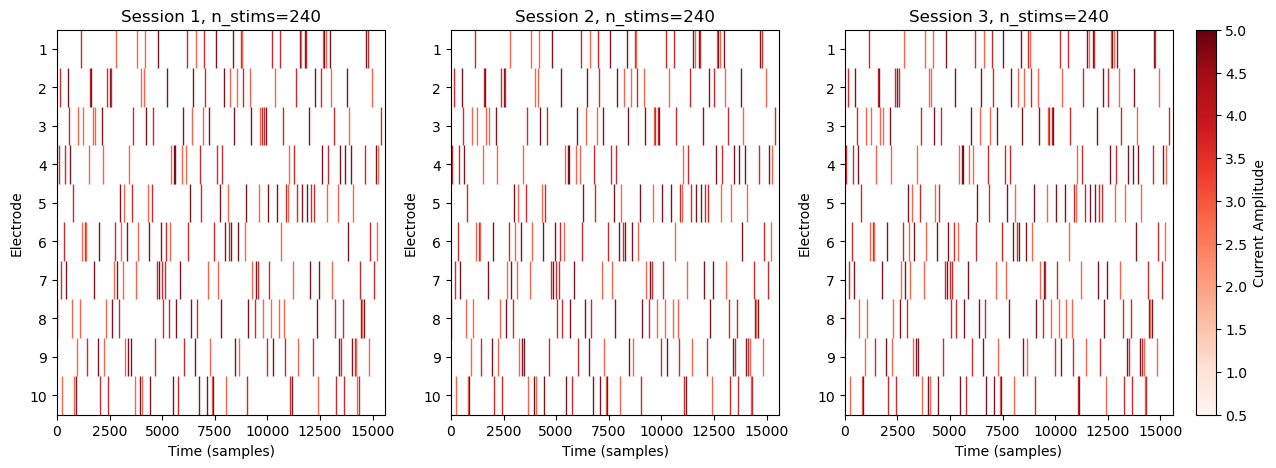

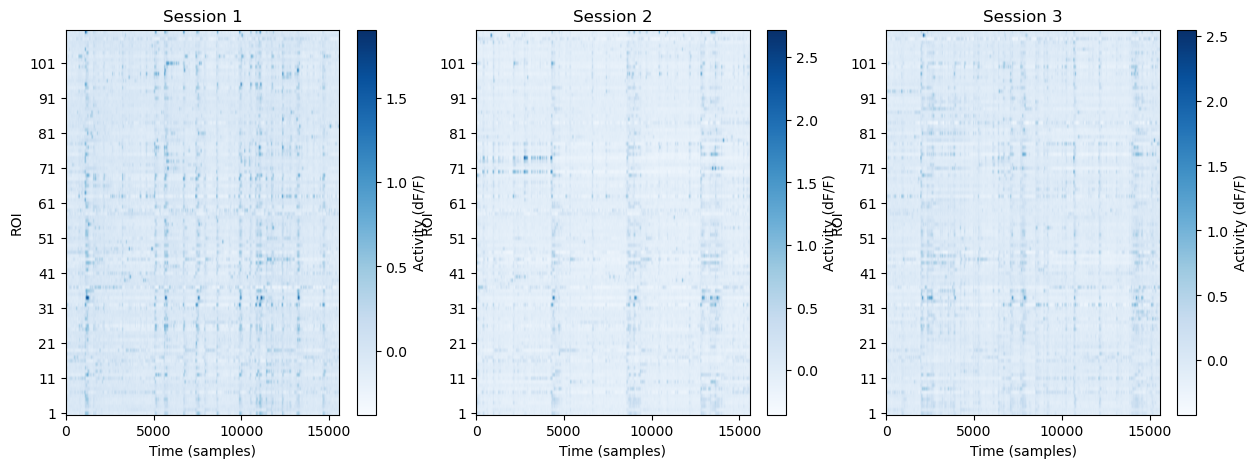

In [90]:
from viz import plot_stim_ticks, plot_activity_per_session
stim_times_sess = []
for session in range(3):
    stim_times = np.zeros((dfof[session].shape[0], 10))
    for config in range(1, 31): # last config is no stim
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
        print(f'Config {config}: Electrode {electrode}, Current {current}')
        for i in range(8):
            config_time = times[session][i,config-1]
            stim_times[config_time, electrode] = current
    stim_times_sess.append(stim_times) # len 3, each (n_times, n_electrodes)

stim_times_sess = np.array(stim_times_sess)
print ("Stim times sess shape: ", stim_times_sess.shape)

# how many frames have no stimulation?
n_no_stim = [stim_times_sess[i].shape[0] - np.count_nonzero(stim_times_sess[i]) for i in range(3)]
print (f'Number of no-stim frames per session: {",".join([str(n) for n in n_no_stim])} assuming 1 ms current pulse')




plot_stim_ticks(stim_times_sess, session_ids=None, tick_width=6, cmap_name='Reds',
                figsize=(15, 5), out_path=f'rnn_training/{DATETIME_STAMP}/stim_times_sessions_ticks.png',
                invert_y=True)

plot_activity_per_session(dfof, session_ids=None,
                          figsize=(15,5),
                          out_path=f'rnn_training/{DATETIME_STAMP}/activity_sessions.png')

In [ ]:
from viz import plot_psth_grid

# Call the function
plot_psth_grid(
    model=model,
    valid_df=valid_df,
    test_indices=test_indices,
    dfof=dfof,
    configs_to_plot=configs_to_plot,
    neurons_by_config=neurons_by_config,
    default_neurons=default_neurons,
    target_neurons=TARGET_NEURONS,
    neuron_to_dfof_idx=neuron_to_dfof_idx,
    neuron_to_output_idx=neuron_to_output_idx,
    device=device,
    snippet_length=SNIPPET_LENGTH,
    stim_delay=STIM_DELAY,
    stim_offset=STIM_OFFSET,
    post_stim_frames=POST_STIM_FRAMES,
    max_trials_per_session=MAX_TRIALS_PER_SESSION,
    psth_dir=psth_dir,
    line_alpha=0.9,
    gt_lw=2.0,
    pred_lw=1.2,
    n_sessions=3,
    subplot_size=4,
)


In [ ]:
trial_colors_8 = blue_to_red_8()

# Ensure we always have all snippets (so we can mix train/test/val in same plot)
source_df = valid_df
n_sessions = 3

TOTAL_DISPLAY_FRAMES = STIM_DELAY + POST_STIM_FRAMES
pred_time_axis = np.arange(SNIPPET_LENGTH) - STIM_DELAY

current_colors = {3: 'red', 4: 'blue', 5: 'green'}

for config in configs_to_plot:
    neurons_of_interest = neurons_by_config.get(str(config), default_neurons)
    if neurons_of_interest is None or len(neurons_of_interest) == 0:
        neurons_of_interest = TARGET_NEURONS
    neurons_of_interest = [n for n in neurons_of_interest if n in TARGET_NEURONS] 

    if config != 31: 
        matching_df = source_df[
            (source_df["first_config"] == config) &
            (source_df["first_stim_time"] == STIM_DELAY)
        ] 
    else: # no stim for 31
        matching_df = source_df[
            (source_df["first_config"] == config)
        ]
    
    logging.info(
        f"Config {config} has {len(matching_df)} matching snippets (stim at t={STIM_DELAY}), "
        f"neurons: {neurons_of_interest}"
    )
    if len(matching_df) == 0:
        continue

    # --- figure: rows=neurons, cols=3 sessions ---
    subplot_size = 2.5  # Reduced from 4 to make the plot smaller
    f, ax = plt.subplots(
        len(neurons_of_interest), n_sessions,
        figsize=(subplot_size * n_sessions, subplot_size * len(neurons_of_interest)),
        sharex=True, sharey=True, squeeze=False
    )

    for row_idx, neuron in enumerate(neurons_of_interest):
        dfof_idx = neuron_to_dfof_idx[neuron]
        output_idx = neuron_to_output_idx[neuron]

        for col_idx in range(n_sessions):
            current_ax = ax[row_idx, col_idx]

            # session subset
            session_df = matching_df[matching_df["session"] == col_idx]
            assert len(session_df) == 8

            stim_lines_added = {3: False, 4: False, 5: False}
            # TODO: MAKE SURE ONLY ONE TEST TRIAL PER SESSION IS PRESENT
            for trial_num, (idx, row) in enumerate(session_df.iterrows(), start=1):
                # trial_num is 1..8
                trial_color = trial_colors_8[trial_num - 1]

                # linestyle encodes split: train dashed, test/val solid
                is_train_or_val = idx not in test_indices 
                split_ls = "--" if is_train_or_val else "-"

                # --- Prediction ---
                stim_input = np.expand_dims(row["stim_snippet"].astype(np.float32), axis=0)
                activity_input = np.expand_dims(row["initial_condition"].astype(np.float32), axis=0)
                stim_input_t = torch.from_numpy(stim_input).to(device)
                activity_input_t = torch.from_numpy(activity_input).to(device)

                with torch.no_grad():
                    outputs = model((stim_input_t, activity_input_t))
                roi_activity = outputs[0, :, output_idx].detach().cpu().numpy()

                current_ax.plot(
                    pred_time_axis, roi_activity,
                    color=trial_color, alpha=LINE_ALPHA,
                    linestyle=split_ls, linewidth=PRED_LW,
                    label=f"Trial {trial_num} Pred" if trial_num == 1 else None
                )

                # --- stimulation vertical lines (keep as before) ---
                stim_snippet = row["stim_snippet"]
                stim_times_idx = np.nonzero(stim_snippet)[0]
                electrodes_idx = np.nonzero(stim_snippet)[1]
                for t_idx, e_idx in zip(stim_times_idx, electrodes_idx):
                    current = int(stim_snippet[t_idx, e_idx])
                    vcol = current_colors.get(current, "gray")
                    vlab = f"Stim (I={current})" if (current in stim_lines_added and not stim_lines_added[current]) else None
                    current_ax.axvline(
                        x=t_idx - STIM_DELAY, color=vcol, linestyle=":", alpha=0.7, label=vlab
                    )
                    if current in stim_lines_added:
                        stim_lines_added[current] = True

            # axes formatting
            current_ax.set_ylim(-0.5, 1.0)
            current_ax.set_yticks([-0.5, 0, 0.5, 1.0])
            # Only label frames 0 and 50 on x axis
            current_ax.set_xticks([0, 50])
            current_ax.set_aspect("auto")

            current_ax.set_title(f"Config {config}, ROI {neuron}, Session {col_idx + 1}")
            current_ax.set_xlabel("Time (frames)")
            current_ax.set_ylabel("Activity")

            # One legend for the whole figure (only once, top-left panel)
            if row_idx == 0 and col_idx == 0:
                legend_elements = [
                    Line2D([0], [0], color="gray", linestyle="-", linewidth=2, label="Test (solid)"),
                    Line2D([0], [0], color="gray", linestyle="--", linewidth=2, label="Train (dashed)"),
                ]
                current_ax.legend(handles=legend_elements, loc="upper right", fontsize="small")

    plt.tight_layout()
    outpath = os.path.join(psth_dir, f"config_{config}_b.png")
    plt.savefig(outpath, dpi=250)
    plt.close(f)
    logging.info(f"Saved combined PSTH: {outpath}")
